# Generate aggregated features

# TOC

* [1-A b](#1-A-b)

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
import gc
import pandas as pd
import numpy as np
from pathlib import Path
from itertools import product
from sklearn import model_selection

# Loading the data

In [3]:
data_dir = Path('.').absolute().joinpath('data')

sales_train = pd.read_csv(data_dir.joinpath('sales_train.csv.gz'))
sales_test = pd.read_csv(data_dir.joinpath('test.csv.gz'))
items = pd.read_csv(data_dir.joinpath('items.csv'))
item_categories = pd.read_csv(data_dir.joinpath('item_categories.csv'))
shops = pd.read_csv(data_dir.joinpath('shops.csv'))

In [4]:
n_train_samples = sales_train.shape[0]

Cast the dates to actual dates for easier manipulation

In [5]:
sales_train.loc[:, 'date'] = pd.to_datetime(sales_train.loc[:, 'date'], format='%d.%m.%Y')

# Cleaning of the dataset

After investigating the item count per day outliners we saw that these may actual be correct (and not arising from typos etc.)

Further, we saw that the outliner in price could be fixed, by converting `'Radmin 3  - 522 лиц.'` to `'Radmin 3  - 1 лиц.'`.

We do the conversion in the following cells

In [6]:
# Values obtained from EDA
item_count_522 = 522
item_id_1 = 6065

In [7]:
max_price = sales_train.loc[:, 'item_price'].max()
high_price = sales_train.loc[sales_train.loc[:, 'item_price'] == max_price]

In [8]:
index = high_price.index[0]

sales_train.loc[index, 'item_id'] = item_id_1
sales_train.loc[index, 'item_cnt_day'] = item_count_522
sales_train.loc[index, 'item_price'] = max_price/item_count_522

Further, we saw that the datapoint for plastic bags had a high item count. As this is used to calculate the renevue below, we will not alter this item

We've seen that that `item_cnt_day` are of floats, to speed up calculations, we transform them to integers

In [9]:
sales_train.loc[:, 'item_cnt_day'] = sales_train.loc[:, 'item_cnt_day'].astype(np.int32)

# Making the base set

We will here use the trick from the ensembling exercise where we create an outer product of the `item_id` and `shop_id` present in each block.

Recall that we are predicting for the `34`th month

In [10]:
sales_test.loc[:, 'date_block_num'] = 34

In [11]:
data = []
cols = ['date_block_num','shop_id','item_id']

# The training part
for block in sales_train.loc[:,'date_block_num'].unique():
    tmp = sales_train.loc[sales_train.loc[:, 'date_block_num'] == block, cols]
    # NOTE: Here we make an outer product of 'date_block_num','shop_id' and 'item_id'
    data.append(np.array(list(product([block], tmp.loc[:,'shop_id'].unique(), tmp.loc[:,'item_id'].unique()))))
    
# Make a sorted dataset of the list
data = pd.DataFrame(np.vstack(data), columns=cols).sort_values(cols)

We do not want to expand the test set, as we will use this for predictions

In [12]:
data = pd.concat([data, sales_test.loc[:, ['date_block_num','shop_id','item_id']]], axis=0)

# Generating aggregated features

## Adding shop features

In [13]:
shop_drop_cols = ['item_price', 'item_cnt_day', 'item_category_id', 'revenue']
shop = pd.merge(sales_train, items.loc[:, ['item_id', 'item_category_id']], how='left', on=['item_id'])

In [14]:
shop.loc[:, 'revenue'] = shop.loc[:, 'item_price'] * shop.loc[:, 'item_cnt_day']

### Sum aggregates

In [15]:
shop_sum = shop.copy()

In [16]:
shop_sum.loc[:, 'month_shop_revenue_sum'] = \
    shop_sum.loc[:, ['date_block_num', 'shop_id', 'revenue']].\
    groupby(['date_block_num', 'shop_id'])['revenue'].transform(sum)

In [17]:
shop_sum.loc[:, 'month_shop_item_id_item_cnt_sum'] = \
    shop_sum.loc[:, ['date_block_num', 'shop_id', 'item_id', 'item_cnt_day']].\
    groupby(['date_block_num', 'shop_id', 'item_id'])['item_cnt_day'].transform(sum)

In [18]:
shop_sum.loc[:, 'month_shop_item_cnt_sum'] = \
    shop_sum.loc[:, ['date_block_num', 'shop_id', 'item_cnt_day']].\
    groupby(['date_block_num', 'shop_id'])['item_cnt_day'].transform(sum)

In [19]:
shop_sum.drop(shop_drop_cols, axis=1, inplace=True)
shop_sum.head()

,date,date_block_num,shop_id,item_id,month_shop_revenue_sum,month_shop_item_id_item_cnt_sum,month_shop_item_cnt_sum
0,2013-01-02,0,59,22154,1633431.00,1,2017
1,2013-01-03,0,25,2552,5376478.13,0,8215
2,2013-01-05,0,25,2552,5376478.13,0,8215
3,2013-01-06,0,25,2554,5376478.13,1,8215
4,2013-01-15,0,25,2555,5376478.13,1,8215


### Mean aggregates

In [20]:
shop_mean = shop.copy()

In [21]:
shop_mean.loc[:, 'shop_revenue_avg'] = \
    shop_mean.loc[:, ['shop_id', 'revenue']].\
    groupby(['shop_id'])['revenue'].transform(np.mean)

In [22]:
shop_mean.loc[:, 'month_shop_item_cnt_avg'] = \
    shop_mean.loc[:, ['date_block_num', 'shop_id', 'item_cnt_day']].\
    groupby(['date_block_num', 'shop_id'])['item_cnt_day'].transform(np.mean)

In [23]:
shop_mean.loc[:, 'month_shop_item_id_item_cnt_avg'] = \
    shop_mean.loc[:, ['date_block_num', 'shop_id', 'item_id', 'item_cnt_day']].\
    groupby(['date_block_num', 'shop_id', 'item_id'])['item_cnt_day'].transform(np.mean)

In [24]:
shop_mean.loc[:, 'month_shop_item_cat_item_cnt_avg'] = \
    shop_mean.loc[:, ['date_block_num', 'shop_id', 'item_category_id', 'item_cnt_day']].\
    groupby(['date_block_num', 'shop_id', 'item_category_id'])['item_cnt_day'].transform(np.mean)

In [25]:
shop_mean.drop(shop_drop_cols, axis=1, inplace=True)
shop_mean.head()

,date,date_block_num,shop_id,item_id,shop_revenue_avg,month_shop_item_cnt_avg,month_shop_item_id_item_cnt_avg,month_shop_item_cat_item_cnt_avg
0,2013-01-02,0,59,22154,1074.061435,1.092041,1.0,1.016949
1,2013-01-03,0,25,2552,1163.223635,1.178454,0.0,0.922222
2,2013-01-05,0,25,2552,1163.223635,1.178454,0.0,0.922222
3,2013-01-06,0,25,2554,1163.223635,1.178454,1.0,0.922222
4,2013-01-15,0,25,2555,1163.223635,1.178454,1.0,1.000000


### Other aggregates

In [26]:
shop_other = shop.copy()

In [27]:
# NOTE: We use a slightly different notation on this feature as it can be merged on shop instead on shop-item
shop_other.loc[:, 'shop_unique_items_len'] = \
    shop_other.loc[:, ['shop_id', 'item_id']].\
    groupby('shop_id')['item_id'].transform(lambda item_id_group: len(np.unique(item_id_group)))

In [28]:
shop_other.loc[:, 'month_shop_item_id_item_cnt_max'] = \
    shop_other.loc[:, ['date_block_num', 'shop_id', 'item_id', 'item_cnt_day']].\
    groupby(['shop_id', 'item_id', 'date_block_num'])['item_cnt_day'].transform(max)

In [29]:
shop_other.loc[:, 'month_shop_item_id_item_cnt_min'] = \
    shop_other.loc[:, ['date_block_num', 'shop_id', 'item_id', 'item_cnt_day']].\
    groupby(['shop_id', 'item_id', 'date_block_num'])['item_cnt_day'].transform(min)

In [30]:
shop_other.drop(shop_drop_cols, axis=1, inplace=True)
shop_other.head()

,date,date_block_num,shop_id,item_id,shop_unique_items_len,month_shop_item_id_item_cnt_max,month_shop_item_id_item_cnt_min
0,2013-01-02,0,59,22154,7336,1,1
1,2013-01-03,0,25,2552,15367,1,-1
2,2013-01-05,0,25,2552,15367,1,-1
3,2013-01-06,0,25,2554,15367,1,1
4,2013-01-15,0,25,2555,15367,1,1


## Adding non-shop features

In [31]:
non_shop_drop_cols = ['item_price', 'item_category_id', 'item_cnt_day']
non_shop = pd.merge(sales_train, items.loc[:, ['item_id', 'item_category_id']], how='left', on=['item_id'])

Aggregates by item and month

In [32]:
non_shop.loc[:, 'month_item_id_item_cnt_sum'] = \
    non_shop.loc[:, ['date_block_num', 'item_id', 'item_cnt_day']].\
    groupby(['date_block_num', 'item_id'])['item_cnt_day'].transform(sum)

In [33]:
non_shop.loc[:, 'month_item_id_item_cnt_avg'] = \
    non_shop.loc[:, ['date_block_num', 'item_id', 'item_cnt_day']].\
    groupby(['date_block_num', 'item_id'])['item_cnt_day'].transform(np.mean)

In [34]:
non_shop.loc[:, 'month_item_cat_item_cnt_avg'] = \
    non_shop.loc[:, ['date_block_num', 'item_category_id', 'item_cnt_day']].\
    groupby(['date_block_num', 'item_category_id'])['item_cnt_day'].transform(np.mean)

In [35]:
non_shop.loc[:, 'month_item_cnt_avg'] = \
    non_shop.loc[:, ['date_block_num', 'item_cnt_day']].\
    groupby(['date_block_num'])['item_cnt_day'].transform(np.mean)

In [36]:
non_shop.loc[:, 'month_item_id_item_cnt_max'] = \
    non_shop.loc[:, ['date_block_num', 'item_id', 'item_cnt_day']].\
    groupby(['date_block_num', 'item_id'])['item_cnt_day'].transform(max)

In [37]:
non_shop.loc[:, 'month_item_id_item_cnt_min'] = \
    non_shop.loc[:, ['date_block_num', 'item_id', 'item_cnt_day']].\
    groupby(['date_block_num', 'item_id'])['item_cnt_day'].transform(min)

In [38]:
non_shop.drop(non_shop_drop_cols, axis=1, inplace=True)
non_shop.head()

,date,date_block_num,shop_id,item_id,month_item_id_item_cnt_sum,month_item_id_item_cnt_avg,month_item_cat_item_cnt_avg,month_item_cnt_avg,month_item_id_item_cnt_max,month_item_id_item_cnt_min
0,2013-01-02,0,59,22154,18,1.0,1.053414,1.136477,1,1
1,2013-01-03,0,25,2552,0,0.0,0.969595,1.136477,1,-1
2,2013-01-05,0,25,2552,0,0.0,0.969595,1.136477,1,-1
3,2013-01-06,0,25,2554,1,1.0,0.969595,1.136477,1,1
4,2013-01-15,0,25,2555,2,1.0,1.007519,1.136477,1,1


#### Clipping the target value

In this comptetition the range of the predicted item count sold should be in the range $[0, 20]$.
This leaves us with two choices:

1. Clipping before training
2. Clipping after prediction

The disatvantage of 1. is that this will give us inconsistencies with other features like the revenue.
However, features like the aggregated revenue of a shop is expected to influence the sales of a shop, so it is not that critical that we reduce the correlation between these features.

On the other hand, if we go for option 2., the range of values which the model is trying to learn from is broad. This can lead to low performance as the target space becomes broad and therefore sparse.

Because of this we clip prior to training.

In [39]:
shop_mean.loc[:, 'month_shop_item_id_item_cnt_avg'].clip(0, 20, inplace=True)

#### Merge and clean-up

In [40]:
shop_sum.drop_duplicates(inplace=True)
shop_mean.drop_duplicates(inplace=True)
shop_other.drop_duplicates(inplace=True)
non_shop.drop_duplicates(inplace=True)

In [41]:
merge_on = ['date', 'date_block_num', 'shop_id', 'item_id']

aggregates = pd.merge(shop_sum, shop_mean, how='left', on=merge_on)
aggregates = pd.merge(aggregates, shop_other, how='left', on=merge_on)
aggregates = pd.merge(aggregates, non_shop, how='left', on=merge_on)

We check that we didn't introduce any `NaN`s or that we accidentally expanded the set 

In [42]:
if aggregates.isnull().any().any():
    raise AssertionError('NaNs were created')
    
n_aggregates = aggregates.shape[0]
if n_aggregates > n_train_samples:
    raise AssertionError(f'The training set was expanded: '
                         f'n_aggregates={n_aggregates} and n_train_samples={n_train_samples}')

We have no longer use of the day information of the aggregates, so we remove this and remove the duplicates.

In [43]:
aggregates.drop('date', axis=1, inplace=True)
aggregates.drop_duplicates(inplace=True)
aggregates.reset_index(inplace=True, drop=True)

In [44]:
print(f'Shape = {aggregates.shape}')
aggregates.head()

Shape = (1609124, 19)


,date_block_num,shop_id,item_id,month_shop_revenue_sum,month_shop_item_id_item_cnt_sum,month_shop_item_cnt_sum,shop_revenue_avg,month_shop_item_cnt_avg,month_shop_item_id_item_cnt_avg,month_shop_item_cat_item_cnt_avg,shop_unique_items_len,month_shop_item_id_item_cnt_max,month_shop_item_id_item_cnt_min,month_item_id_item_cnt_sum,month_item_id_item_cnt_avg,month_item_cat_item_cnt_avg,month_item_cnt_avg,month_item_id_item_cnt_max,month_item_id_item_cnt_min
0,0,59,22154,1633431.00,1,2017,1074.061435,1.092041,1.0,1.016949,7336,1,1,18,1.0,1.053414,1.136477,1,1
1,0,25,2552,5376478.13,0,8215,1163.223635,1.178454,0.0,0.922222,15367,1,-1,0,0.0,0.969595,1.136477,1,-1
2,0,25,2554,5376478.13,1,8215,1163.223635,1.178454,1.0,0.922222,15367,1,1,1,1.0,0.969595,1.136477,1,1
3,0,25,2555,5376478.13,1,8215,1163.223635,1.178454,1.0,1.000000,15367,1,1,2,1.0,1.007519,1.136477,1,1
4,0,25,2564,5376478.13,1,8215,1163.223635,1.178454,1.0,1.000000,15367,1,1,5,1.0,0.990113,1.136477,1,1


We rejoin `item_category_id` as we will use this as a categorical feature

In [45]:
aggregates = pd.merge(aggregates, items.loc[:, ['item_id', 'item_category_id']], how='left', on='item_id')
print(f'Shape = {aggregates.shape}')

Shape = (1609124, 20)


In [46]:
del shop
del shop_sum
del shop_mean
del shop_other
del non_shop
gc.collect()

350

# Aggregate EDA

We have now added several aggregated features.
In this section, we are in particular interested in exploring the relation between the categorical features and the target variable.

This exploration will be the fundation to create mean encodings, where the purpose is to code the categorical features (with a lot of features) in such a way that the relation with the target variable is taken into account. 

In [47]:
target = 'month_shop_item_id_item_cnt_sum'

<IPython.core.display.Javascript object>


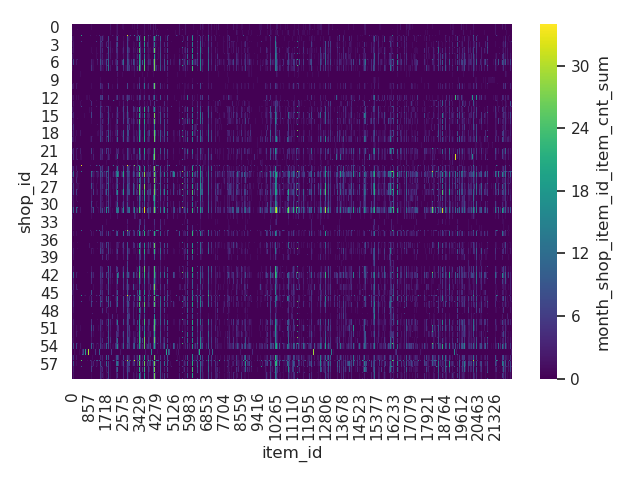

In [48]:
shop_item_id_item_cnt_pivot = \
    aggregates.pivot_table(index='shop_id',
                           columns='item_id',
                           values=target,
                           aggfunc='count',
                           fill_value=0)
fig, ax = plt.subplots()
sns.heatmap(shop_item_id_item_cnt_pivot,
            ax=ax,
            cbar=True,
            cmap='viridis', 
            cbar_kws={'label': target})
plt.tight_layout()

We can see that certain items (for example around id $3429$ and $4279$) are sold broadly across all shops, that some shops have quite broad selection (between shop id $24$ and $33$).

We see that with the current encoding, the shops are not clustred around certain items, but are scattered around.

<IPython.core.display.Javascript object>


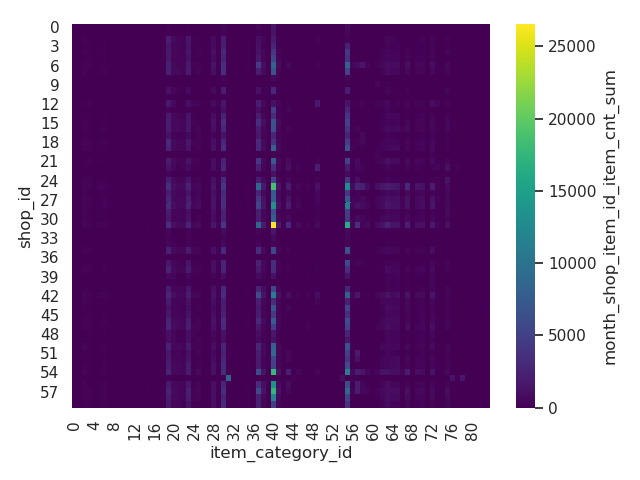

In [49]:
shop_item_cat_item_cnt_pivot = \
    aggregates.pivot_table(index='shop_id',
                           columns='item_category_id',
                           values=target,
                           aggfunc='count',
                           fill_value=0)
fig, ax = plt.subplots()
sns.heatmap(shop_item_cat_item_cnt_pivot,
            ax=ax,
            cbar=True,
            cmap='viridis', 
            cbar_kws={'label': target})
plt.tight_layout()

We observe that a few categories are dominating the sales (like category $40$ and $56$), and the others are contributing less.

<IPython.core.display.Javascript object>


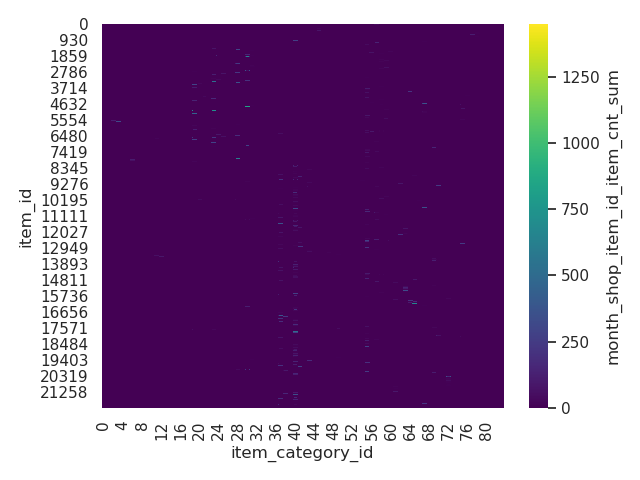

In [50]:
item_id_item_cat_item_cnt_pivot = \
    aggregates.pivot_table(index='item_id',
                           columns='item_category_id',
                           values=target,
                           aggfunc='count',
                           fill_value=0)
fig, ax = plt.subplots()
sns.heatmap(item_id_item_cat_item_cnt_pivot,
            ax=ax,
            cbar=True,
            cmap='viridis', 
            cbar_kws={'label': target})
plt.tight_layout()

It does not appear that the `item_id` is sorted in terms of `item_category_id`, hence will both provide information to the data set.

<IPython.core.display.Javascript object>


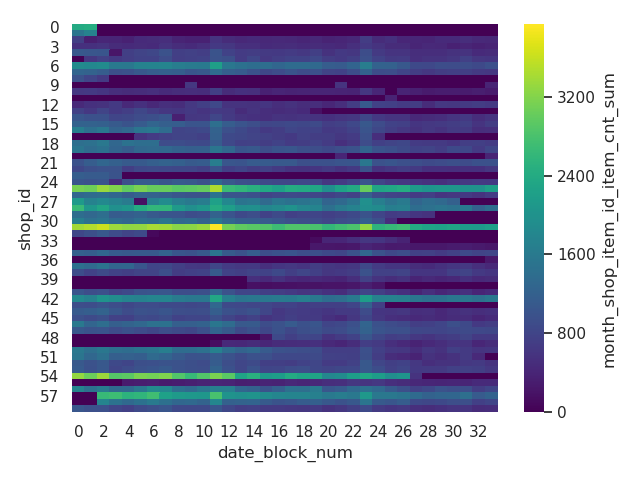

In [51]:
shop_date_block_num_item_cnt_pivot = \
    aggregates.pivot_table(index='shop_id',
                           columns='date_block_num',
                           values=target,
                           aggfunc='count',
                           fill_value=0)
fig, ax = plt.subplots()
sns.heatmap(shop_date_block_num_item_cnt_pivot,
            ax=ax,
            cbar=True,
            cmap='viridis', 
            cbar_kws={'label': target})
plt.tight_layout()

As with the EDA of the raw features, we see that we have seasonal trends, and that a few shops are dominating in terms of quantity.

## Conclusion

From the investigation above, we can argue that it would make sense to create mean encodings for all the categorical features, as they all appear to bring new information to the table.

# Adding mean encoding

We will now mean encode the categorical features above based on how often (on average) the target variable appears in the categorical feature

In [52]:
cat_features = ['item_id', 'shop_id', 'item_category_id']

In [53]:
kf = model_selection.KFold(n_splits=5, shuffle=False)
new_features = []

# Shortly told we will here aggregate a mean on the training set, 
# store it in the validation set and fill the missing values with the global mean
for train_indices, valid_indices in kf.split(aggregates):
    
    # Train/validation split
    train = aggregates.iloc[train_indices]
    valid = aggregates.iloc[valid_indices]
    
    # Mean encoding
    for feature in cat_features:
        # NOTE: The lines below are equivalent to
        # agg_mean = train.loc[:, [feature, target]].groupby(feature)[target].mean()
        # mean_merged_on_valid_feature = 
        #     pd.merge(valid.loc[:, [feature]], agg_mean.to_frame(), how='left', on=feature).loc[:, feature]
        mean_merged_on_valid_feature = valid.loc[:, feature].map(train.groupby(feature)[target].mean())
    
        # Store the results in aggregates
        aggregates.loc[valid_indices, feature + '_mean_enc'] = mean_merged_on_valid_feature
        
global_mean = aggregates.loc[:, target].mean()
aggregates.fillna(global_mean, inplace=True)

In [54]:
aggregates.head()

,date_block_num,shop_id,item_id,month_shop_revenue_sum,month_shop_item_id_item_cnt_sum,month_shop_item_cnt_sum,shop_revenue_avg,month_shop_item_cnt_avg,month_shop_item_id_item_cnt_avg,month_shop_item_cat_item_cnt_avg,...,month_item_id_item_cnt_sum,month_item_id_item_cnt_avg,month_item_cat_item_cnt_avg,month_item_cnt_avg,month_item_id_item_cnt_max,month_item_id_item_cnt_min,item_category_id,item_id_mean_enc,shop_id_mean_enc,item_category_id_mean_enc
0,0,59,22154,1633431.00,1,2017,1074.061435,1.092041,1.0,1.016949,...,18,1.0,1.053414,1.136477,1,1,37,1.071429,1.959963,1.506316
1,0,25,2552,5376478.13,0,8215,1163.223635,1.178454,0.0,0.922222,...,0,0.0,0.969595,1.136477,1,-1,58,1.000000,2.785593,1.115859
2,0,25,2554,5376478.13,1,8215,1163.223635,1.178454,1.0,0.922222,...,1,1.0,0.969595,1.136477,1,1,58,2.267524,2.785593,1.115859
3,0,25,2555,5376478.13,1,8215,1163.223635,1.178454,1.0,1.000000,...,2,1.0,1.007519,1.136477,1,1,56,1.000000,2.785593,1.392657
4,0,25,2564,5376478.13,1,8215,1163.223635,1.178454,1.0,1.000000,...,5,1.0,0.990113,1.136477,1,1,59,1.105263,2.785593,1.158399


Let's investigate how correlated the mean encodings are

In [55]:
mean_enc_cols = [col for col in aggregates.columns if 'mean_enc' in col]
corr_coef = aggregates.loc[:,[target, *mean_enc_cols]].corr()

In [56]:
corr_coef.loc[mean_enc_cols, target].to_frame()

,month_shop_item_id_item_cnt_sum
item_id_mean_enc,0.467335
shop_id_mean_enc,0.061521
item_category_id_mean_enc,0.446748


<IPython.core.display.Javascript object>


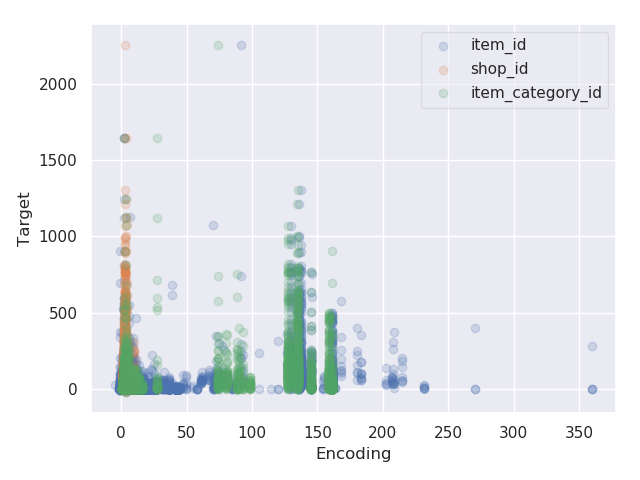

In [57]:
fig, ax = plt.subplots()
ax.scatter(aggregates.loc[:, 'item_id_mean_enc'], aggregates.loc[:, target], label='item_id', alpha=0.2)
ax.scatter(aggregates.loc[:, 'shop_id_mean_enc'], aggregates.loc[:, target], label='shop_id', alpha=0.2)
ax.scatter(aggregates.loc[:, 'item_category_id_mean_enc'], aggregates.loc[:, target], label='item_category_id', alpha=0.2)
ax.set_ylabel('Target')
ax.set_xlabel('Encoding')
ax.legend(loc='best', fancybox=True, framealpha=0.5)
plt.tight_layout()

We see that the mean encodings are relatively well correlated with the target, and it doesn't appear that there is too much leakage.

Notice, however that the categorical features may be multivalued with respect to the mean encoding (due to the k-fold validation).
This becomes a problem when we will merge the encoded values to the test set.
To solve this, we will aggregate a mean of the mean encoding and merge this with the data data frame.

In [58]:
aggregates.loc[:, 'item_id_mean_mean_enc'] = \
    aggregates.loc[:, ['item_id_mean_enc', 'item_id']].\
    groupby(['item_id'])['item_id_mean_enc'].transform(np.mean)

aggregates.loc[:, 'shop_id_mean_mean_enc'] = \
    aggregates.loc[:, ['shop_id_mean_enc', 'shop_id']].\
    groupby(['shop_id'])['shop_id_mean_enc'].transform(np.mean)

aggregates.loc[:, 'item_category_id_mean_mean_enc'] = \
    aggregates.loc[:, ['item_category_id_mean_enc', 'item_category_id']].\
    groupby(['item_category_id'])['item_category_id_mean_enc'].transform(np.mean)

In [59]:
mean_mean_enc_cols = [col for col in aggregates.columns if 'mean_mean_enc' in col]
corr_coef = aggregates.loc[:,[target, *mean_mean_enc_cols]].corr()

In [60]:
corr_coef.loc[mean_mean_enc_cols, target].to_frame()

,month_shop_item_id_item_cnt_sum
item_id_mean_mean_enc,0.526365
shop_id_mean_mean_enc,0.065694
item_category_id_mean_mean_enc,0.472514


<IPython.core.display.Javascript object>


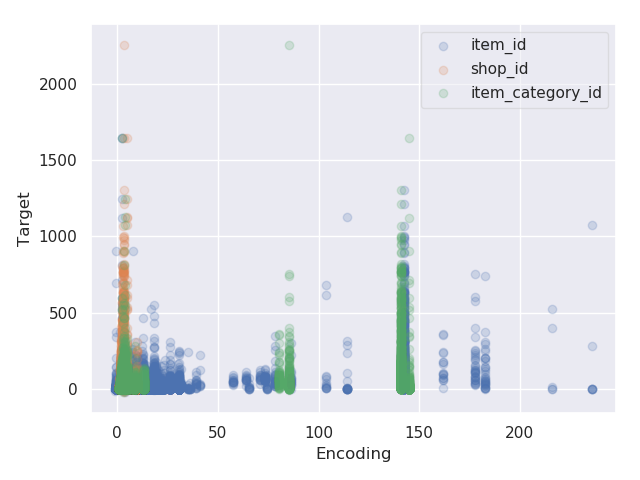

In [61]:
fig, ax = plt.subplots()
ax.scatter(aggregates.loc[:, 'item_id_mean_mean_enc'], aggregates.loc[:, target], label='item_id', alpha=0.2)
ax.scatter(aggregates.loc[:, 'shop_id_mean_mean_enc'], aggregates.loc[:, target], label='shop_id', alpha=0.2)
ax.scatter(aggregates.loc[:, 'item_category_id_mean_mean_enc'], aggregates.loc[:, target], label='item_category_id', alpha=0.2)
ax.set_ylabel('Target')
ax.set_xlabel('Encoding')
ax.legend(loc='best', fancybox=True, framealpha=0.5)
plt.tight_layout()

We see that the main features of the main encoding is preserved.
We therefore remove the original mean encoded features from the aggregated data frame.

In [62]:
aggregates.drop(['item_id_mean_enc', 'shop_id_mean_enc', 'item_category_id_mean_enc'], axis=1, inplace=True)

# Merging the aggregated features with the data dataframe

Before we make the temporal features, we start by mergning the aggregated features with the data dataframe in order to easily add the lagged features to the test set (month $34$ in the data data frame).

**NOTE**: This section is long, and could probably be improved quite a bit. Essentially what happens is that we merge the different part of the aggregated data frame on the correct columns of the data data frame.

In [63]:
n_data_samples = data.shape[0]

We start by merging the item category id with the data data frame as we will later use item category as our merge-on column

In [64]:
merge_on = ['item_id']
data_aggregate = pd.merge(data,
                          items.loc[:, merge_on + ['item_category_id']],
                          how='left', 
                          on=merge_on)

Note that the different columns have different feature dependencies. We must ensure that we are merging the columns on the correct features:

In [65]:
current_cols = set(aggregates.columns)

mean_enc_cols = [col for col in current_cols if 'mean_mean_enc' in col]

current_cols -= set(mean_enc_cols)

In [66]:
month_shop_item_id_cols = [col for col in current_cols if 
                           'month' in col and
                           'shop' in col and
                           'item_id' in col]

current_cols -= set(month_shop_item_id_cols)

In [67]:
month_shop_item_cat_cols = [col for col in current_cols if 
                            'month' in col and
                            'shop' in col and
                            'item_cat' in col]

current_cols -= set(month_shop_item_cat_cols)

In [68]:
month_shop_cols = [col for col in current_cols if 
                   'month' in col and
                   'shop' in col]

current_cols -= set(month_shop_cols)

In [69]:
month_item_id_cols = [col for col in current_cols if 
                      'month' in col and
                      'item_id' in col]

current_cols -= set(month_item_id_cols)

In [70]:
month_item_cat_cols = [col for col in current_cols if 
                       'month' in col and
                       'item_cat' in col]

current_cols -= set(month_item_cat_cols)

In [71]:
month_cols = [col for col in current_cols if 
              'month' in col]

current_cols -= set(month_cols)

In [72]:
shop_cols = [col for col in current_cols if 
            'shop' in col and
             col != 'shop_id']

identifier_cols = current_cols - set(shop_cols)

Check that we did the correct thing

In [73]:
if set(identifier_cols) != {'date_block_num', 'item_category_id', 'item_id', 'shop_id'}:
    raise AssertionError('identifier_cols is not correct')

Merge

In [74]:
merge_on = ['date_block_num', 'shop_id', 'item_id']
data_aggregate = pd.merge(data_aggregate,
                          aggregates.loc[:, merge_on + month_shop_item_id_cols].drop_duplicates(),
                          how='left', 
                          on=merge_on)

As we have expanded our dataset with shop id - item id combinations that have not been sold during that month, we can safely replace the `NaN`s prior to week $34$ to $0$.

In [75]:
# NOTE: The inplace operator seem not to work (maybe because we are selecting a slice)
#       Hence we use the assign operator
data_aggregate.loc[data_aggregate.loc[:, 'date_block_num']<34, month_shop_item_id_cols] =\
    data_aggregate.loc[data_aggregate.loc[:, 'date_block_num']<34, month_shop_item_id_cols].fillna(0)

In [76]:
merge_on = ['date_block_num', 'shop_id', 'item_category_id']
data_aggregate = pd.merge(data_aggregate,
                          aggregates.loc[:, merge_on + month_shop_item_cat_cols].drop_duplicates(),
                          how='left', 
                          on=merge_on)

Due to the shop id - item id expansion, new combinations of shop id - item category id may appear. 
We can alson safely replace the `NaN`s prior to week $34$ to $0$.

In [77]:
# NOTE: The inplace operator seem not to work (maybe because we are selecting a slice)
#       Hence we use the assign operator
data_aggregate.loc[data_aggregate.loc[:, 'date_block_num']<34, month_shop_item_cat_cols] =\
    data_aggregate.loc[data_aggregate.loc[:, 'date_block_num']<34, month_shop_item_cat_cols].fillna(0)

In [78]:
merge_on = ['date_block_num', 'shop_id']
data_aggregate = pd.merge(data_aggregate, 
                          aggregates.loc[:, merge_on + month_shop_cols].drop_duplicates(), 
                          how='left',
                          on=merge_on)

No new `NaN`s should appear after the above merge as the expansion of the training set does not introduce new shops.

In [79]:
merge_on = ['date_block_num', 'item_id']
data_aggregate = pd.merge(data_aggregate,
                          aggregates.loc[:, merge_on + month_item_id_cols].drop_duplicates(),
                          how='left',
                          on=merge_on)

No new `NaN`s should appear after the above merge as the expansion of the training set does not introduce new items.

In [80]:
merge_on = ['date_block_num', 'item_category_id']
data_aggregate = pd.merge(data_aggregate,
                          aggregates.loc[:, merge_on + month_item_cat_cols].drop_duplicates(),
                          how='left',
                          on=merge_on)

No new `NaN`s should appear after the above merge as the expansion of the training set does not introduce new item categories.

In [81]:
merge_on = ['date_block_num']
data_aggregate = pd.merge(data_aggregate,
                          aggregates.loc[:, merge_on + month_cols].drop_duplicates(), 
                          how='left',
                          on=merge_on)

No new `NaN`s should appear after the above merge as the expansion of the training set does not introduce new months.

In [82]:
merge_on = ['shop_id']
data_aggregate = pd.merge(data_aggregate,
                          aggregates.loc[:, merge_on + shop_cols].drop_duplicates(),
                          how='left', 
                          on=merge_on)

No new `NaN`s should appear after the above merge as the expansion of the training set does not introduce new shops.

Finally, we merge the mean encoded features:

In [83]:
merge_on = ['shop_id']
data_aggregate = pd.merge(data_aggregate, 
                          aggregates.loc[:, merge_on + ['shop_id_mean_mean_enc']].drop_duplicates(),
                          how='left',
                          on=merge_on)

No new `NaN`s should appear after the above merge as the expansion of the training set does not introduce new shops.

In [84]:
merge_on = ['item_id']
data_aggregate = pd.merge(data_aggregate, 
                          aggregates.loc[:, merge_on + ['item_id_mean_mean_enc']].drop_duplicates(),
                          how='left',
                          on=merge_on)

No new `NaN`s should appear after the above merge as the expansion of the training set does not introduce new items.

In [85]:
merge_on = ['item_category_id']
data_aggregate = pd.merge(data_aggregate, 
                          aggregates.loc[:, merge_on + ['item_category_id_mean_mean_enc']].drop_duplicates(),
                          how='left',
                          on=merge_on)

No new `NaN`s should appear after the above merge as the expansion of the training set does not introduce new categories.

We check that we didn't introduce any `NaN`s in the training set or that we accidentally expanded the set 

In [86]:
if data_aggregate.loc[data_aggregate.loc[:, 'date_block_num']<34].isnull().any().any():
    raise AssertionError('NaNs were created')
    
n_data_aggregate = data_aggregate.shape[0]
if n_aggregates > n_data_samples:
    raise AssertionError(f'The set was expanded: '
                         f'n_aggregates={n_aggregates} and n_data_aggregate={n_data_aggregate}')

Only two type of features should now contain `NaN`s in the test set:

* Monthly features - as these are based on item counts not present in the test set
* Item id features - as the test set contains new items

In [87]:
test_nan_features = data_aggregate.loc[data_aggregate.loc[:, 'date_block_num']==34].isnull().any()
print(test_nan_features)

date_block_num                      False
shop_id                             False
item_id                             False
item_category_id                    False
month_shop_item_id_item_cnt_sum      True
month_shop_item_id_item_cnt_avg      True
month_shop_item_id_item_cnt_max      True
month_shop_item_id_item_cnt_min      True
month_shop_item_cat_item_cnt_avg     True
month_shop_revenue_sum               True
month_shop_item_cnt_sum              True
month_shop_item_cnt_avg              True
month_item_id_item_cnt_sum           True
month_item_id_item_cnt_max           True
month_item_id_item_cnt_avg           True
month_item_id_item_cnt_min           True
month_item_cat_item_cnt_avg          True
month_item_cnt_avg                   True
shop_revenue_avg                    False
shop_unique_items_len               False
shop_id_mean_mean_enc               False
item_id_mean_mean_enc                True
item_category_id_mean_mean_enc      False
dtype: bool


We check that the monthly features contains only `NaN`s

In [88]:
cols_w_month = [col for col in data_aggregate.columns if 'month' in col]
if not data_aggregate.loc[data_aggregate.loc[:, 'date_block_num']==34, cols_w_month].isnull().all().all():
    raise AssertionError('The monthly features contained something else than NaNs')   

We need to fill the `NaN` values for the non-month features

In [89]:
nan_col = [col for col, is_nan in zip(test_nan_features.index, test_nan_features.values) if is_nan]
non_month_nan_cols = [col for col in data_aggregate.columns if col not in cols_w_month and col in nan_col]
print(non_month_nan_cols)

['item_id_mean_mean_enc']


There are several options to fill these values.
As we saw from the EDA of the raw data, only $1.6 %$ of the item ids were present in the test set that was not present in the training set. 
Thus, it should not matter too much what we fill these values with. 
We choose to use the mean encoding trick and fill them with the global mean.

In [90]:
data_aggregate.loc[:, 'item_id_mean_mean_enc'].fillna(global_mean, inplace=True)

# Adding temporal history

As this is a sequential problem, we would like to incorperate some time information into the training set.

Note that all the montly aggregated features we generated above will only be present as lagged features in the test set when we create the lagged features.

In [91]:
def make_lagged(df, col, lags, merge_on, fillna=0):
    """
    Makes lagged features
    
    We make the lag this by adding the lag number to date_block_num
    and merge the result on date_block_num of the corresponding month of the input df.
    
    Parameters
    ----------
    df : DataFrame
        The feature to make lagged features from
    col : str
        The name of the feature
    lags : list
        The number of months to lag
    merge_on : list
        The columns to merge on
    fillna : float
        The value to fill the NaNs with
    
    Returns
    -------
    lag_df : DataFrame
        A DataFrame containing the lagged features
    """
    
    lag_df = df.loc[:, merge_on + [col]].copy()
    
    samples = lag_df.shape[0]
    
    for lag in lags:
        print(f'Processing lag {lag}', end='\r')
        tmp_df = lag_df.copy()
        tmp_df.loc[:, 'date_block_num'] = tmp_df.loc[:, 'date_block_num'] + lag
        new_col = f'{col}_lag_{lag}'
        tmp_df.rename({col: new_col}, axis=1, inplace=True)
        tmp_df.drop_duplicates(inplace=True)
        lag_df = pd.merge(lag_df, tmp_df.loc[:, [*merge_on, new_col]], how='left', on=merge_on)
    
    lag_df.fillna(fillna, inplace=True)
    
    # Drop the original feature
    lag_df.drop(col, axis=1, inplace=True)
    
    cur_samples = lag_df.shape[0]
    if cur_samples > samples:
        raise AssertionError(f'Sample size increased. Old: {samples}, new: {cur_samples}')
    
    return lag_df

Our strategy is to lag the features in the following way:

**Long lag** (i.e. by $1$, $2$, $3$, $6$, $9$ and $12$ months):
These are the features which time trend is belived to be most important for prediction
* Merge on: month, shop, item
    * `month_shop_item_id_item_cnt_sum`
* Merge on: month, shop
    * `month_shop_item_cnt_sum`
* Merge on: month, item
    * `month_item_id_item_cnt_sum`

**Short lag** (i.e. by only $1$ month)
These are the features which time trend is belived to be less important for prediction
* Merge on: month, shop, item
    * `month_shop_item_id_item_cnt_max`
    * `month_shop_item_id_item_cnt_min`
    * `month_shop_item_id_item_cnt_avg`
* Merge on: month, shop, category
    * `month_shop_item_cat_item_cnt_avg`
* Merge on: month, shop
    * `month_shop_item_cnt_avg`
    * `month_shop_revenue_sum`
* Merge on: month, item
    * `month_item_id_item_cnt_max`
    * `month_item_id_item_cnt_min`
    * `month_item_id_item_cnt_avg`
* Merge on: month, category
    * `month_item_cat_item_cnt_avg`
* Merge on: month
    * `month_item_cnt_avg`

**Fillna strategy**:

For the shop-item combinations we can safely fill the resulting `NaN`s with $0$ as the combination simply did not sell anything the previous `lag`-months.
In fact, the same argument goes for all other mergin strategies as well.

## Long time lag

In [92]:
long_lags = [1, 2, 3, 6, 9, 12]

In [93]:
merge_on = ['date_block_num', 'item_id', 'shop_id']
tmp = make_lagged(df=data_aggregate,
                  col='month_shop_item_id_item_cnt_sum',
                  lags=long_lags,
                  merge_on=merge_on)

We make a minor sanity check: We select the highest number of `'month_shop_item_id_item_cnt_sum'` which is in a month where the lag is visible in the last lag feature, and see if the number is constant for the lag months

In [94]:
col = 'month_shop_item_id_item_cnt_sum'
rows = data_aggregate.loc[(data_aggregate.loc[:, col]==\
                           data_aggregate.loc[data_aggregate.loc[:, 'date_block_num']<33-max(long_lags), col].max())]

month = rows.loc[:, 'date_block_num'].values[0]
shop_id = rows.loc[:, 'shop_id'].values[0]
item_id = rows.loc[:, 'item_id'].values[0]
val = rows.loc[:, col].values[0]

for lag in long_lags:
    lagged_val = tmp.loc[(tmp.loc[:, 'date_block_num'] == month + lag) & 
                   (tmp.loc[:, 'shop_id'] == shop_id) &
                   (tmp.loc[:, 'item_id'] == item_id),
                   merge_on + [f'{col}_lag_{lag}']].drop_duplicates().\
                 loc[:, f'{col}_lag_{lag}']
    if not np.isclose(val, lagged_val):
        raise AssertionError('Oh dear, something is wrong with the lag function...')

print('Lag function looks OK!')

Lag function looks OK!


In [95]:
data_aggregate = pd.merge(data_aggregate, tmp.drop_duplicates(), how='left', on=merge_on)

In [96]:
def add_lagged_feature(df, col, merge_on, lags):
    """
    Add a feature to the input data frame
    
    Parameters
    ----------
    df : DataFrame
        The data frame to add the lagged features to
    col : str
        The feature to add make the lagged feature of
    merge_on : list
        List of features to merge on
    lags : list
        The lags

    Returns
    -------
    df : DataFrame
        The data frame with added features
    """
    tmp = make_lagged(df=df,
                      col=col,
                      lags=lags,
                      merge_on=merge_on)
    df = pd.merge(df, tmp.drop_duplicates(), how='left', on=merge_on)
    
    return df

In [97]:
merge_on = ['date_block_num', 'shop_id']
data_aggregate = add_lagged_feature(data_aggregate, 'month_shop_item_cnt_sum', merge_on, long_lags)

In [98]:
merge_on = ['date_block_num', 'item_id']
data_aggregate = add_lagged_feature(data_aggregate, 'month_item_id_item_cnt_sum', merge_on, long_lags)

## Short time lag

In [99]:
short_lags = [1]

In [100]:
merge_on = ['date_block_num', 'shop_id', 'item_id']
data_aggregate = add_lagged_feature(data_aggregate, 'month_shop_item_id_item_cnt_max', merge_on, short_lags)
data_aggregate = add_lagged_feature(data_aggregate, 'month_shop_item_id_item_cnt_min', merge_on, short_lags)
data_aggregate = add_lagged_feature(data_aggregate, 'month_shop_item_id_item_cnt_avg', merge_on, short_lags)

In [101]:
merge_on = ['date_block_num', 'shop_id', 'item_category_id']
data_aggregate = add_lagged_feature(data_aggregate, 'month_shop_item_cat_item_cnt_avg', merge_on, short_lags)

In [102]:
merge_on = ['date_block_num', 'shop_id']
data_aggregate = add_lagged_feature(data_aggregate, 'month_shop_item_cnt_avg', merge_on, short_lags)
data_aggregate = add_lagged_feature(data_aggregate, 'month_shop_revenue_sum', merge_on, short_lags)

In [103]:
merge_on = ['date_block_num', 'item_id']
data_aggregate = add_lagged_feature(data_aggregate, 'month_item_id_item_cnt_max', merge_on, short_lags)
data_aggregate = add_lagged_feature(data_aggregate, 'month_item_id_item_cnt_min', merge_on, short_lags)
data_aggregate = add_lagged_feature(data_aggregate, 'month_item_id_item_cnt_avg', merge_on, short_lags)

In [104]:
merge_on = ['date_block_num', 'item_category_id']
data_aggregate = add_lagged_feature(data_aggregate, 'month_item_cat_item_cnt_avg', merge_on, short_lags)

In [105]:
merge_on = ['date_block_num']
data_aggregate = add_lagged_feature(data_aggregate, 'month_item_cnt_avg', merge_on, short_lags)

Verfiy that we did not introduced `NaN`s after the last 

In [106]:
cols_w_lag = [col for col in data_aggregate.columns if '_lag_' in col]
if data_aggregate.loc[data_aggregate.loc[:, 'date_block_num'] > max(long_lags), cols_w_lag].isnull().any().any():
    raise AssertionError('The monthly features contained something else than NaNs')
    
if data_aggregate.shape[0] > n_data_samples:
    raise AssertionError(f'The set was expanded: '
                         f'n_aggregates={n_aggregates} and n_data_aggregate={n_data_aggregate}')

In [107]:
del tmp
gc.collect()

321

# Storing the data frame

Our data now consist of the following columns

In [108]:
sorted(data_aggregate.columns)

['date_block_num',
 'item_category_id',
 'item_category_id_mean_mean_enc',
 'item_id',
 'item_id_mean_mean_enc',
 'month_item_cat_item_cnt_avg',
 'month_item_cat_item_cnt_avg_lag_1',
 'month_item_cnt_avg',
 'month_item_cnt_avg_lag_1',
 'month_item_id_item_cnt_avg',
 'month_item_id_item_cnt_avg_lag_1',
 'month_item_id_item_cnt_max',
 'month_item_id_item_cnt_max_lag_1',
 'month_item_id_item_cnt_min',
 'month_item_id_item_cnt_min_lag_1',
 'month_item_id_item_cnt_sum',
 'month_item_id_item_cnt_sum_lag_1',
 'month_item_id_item_cnt_sum_lag_12',
 'month_item_id_item_cnt_sum_lag_2',
 'month_item_id_item_cnt_sum_lag_3',
 'month_item_id_item_cnt_sum_lag_6',
 'month_item_id_item_cnt_sum_lag_9',
 'month_shop_item_cat_item_cnt_avg',
 'month_shop_item_cat_item_cnt_avg_lag_1',
 'month_shop_item_cnt_avg',
 'month_shop_item_cnt_avg_lag_1',
 'month_shop_item_cnt_sum',
 'month_shop_item_cnt_sum_lag_1',
 'month_shop_item_cnt_sum_lag_12',
 'month_shop_item_cnt_sum_lag_2',
 'month_shop_item_cnt_sum_lag_3',


In [109]:
generated_data = Path('.').absolute().joinpath('generated_data')
generated_data.mkdir(exist_ok=True)

data_aggregate.to_hdf(generated_data.joinpath('data_aggregate.hdf'),
                      key='data_aggregate')